In [41]:
# Import dependencies
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, text

DEBUG = True

In [42]:
# load the full database (this database is created via create_db.ipynb from the csv files in the Resources directory which need to be downloaded from Kaggle)
engine = create_engine("sqlite:///open_university.sqlite", echo=False)

## Load the data

The plan is to just look at the interaction with the course material to see if the student will be able to predict if the student will pass or fail.

Not including information about the background of the student (demographics) or the scores of the student assessments but include if they submit the assessments or not.

We are going to filter out students that withdraw from the course before the start of the course.

In [43]:
# load a subset of the student data
student_ds = engine.execute(text("""
SELECT sI.code_module, sI.code_presentation, sI.id_student, sI.final_result, sR.date_registration, sR.date_unregistration
FROM studentInfo as sI
LEFT JOIN studentRegistration as sR ON sI.id_student = sR.id_student
WHERE NOT (sR.date_unregistration <= -11 AND sI.final_result = 'Withdrawn')
""")).fetchall()

# Remove all students that withdraw before 11 days before the course
# these students would not have interacted with the course material

student_df = pd.DataFrame(student_ds, columns=['code_module', 'code_presentation', 'id_student', 'final_result', 'date_registration', 'date_unregistration'])
student_df = student_df.astype({'code_module':'string', 'code_presentation':'string', 'id_student':'string', 'final_result':'string'})
student_df.head()

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,Pass,-159.0,NaN
1,AAA,2013J,28400,Pass,-53.0,NaN
2,AAA,2013J,30268,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,Pass,-52.0,NaN
4,AAA,2013J,32885,Pass,-176.0,NaN


In [44]:
student_df.info()
# view the number of unique values in each of the fields
display(student_df.nunique())
# have a closer look at the final results

student_pass    = student_df['final_result'].loc[(student_df['final_result'] == 'Distinction') | (student_df['final_result'] == 'Pass')].value_counts()
student_results = student_df['final_result'].value_counts()

display(student_results)

print(f"{student_pass.sum()} passing grades over {student_results.sum()} total grades in 7 courses over the 4 presentations of the courses")
print(f"This is telling us that some of the students participated in more than one course over the 4 presentations")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36688 entries, 0 to 36687
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          36688 non-null  string 
 1   code_presentation    36688 non-null  string 
 2   id_student           36688 non-null  string 
 3   final_result         36688 non-null  string 
 4   date_registration    36666 non-null  float64
 5   date_unregistration  11592 non-null  float64
dtypes: float64(2), string(4)
memory usage: 1.7 MB


code_module                7
code_presentation          4
id_student             27295
final_result               4
date_registration        320
date_unregistration      355
dtype: int64

final_result
Pass           14682
Withdrawn       9904
Fail            8478
Distinction     3624
Name: count, dtype: Int64

18306 passing grades over 36688 total grades in 7 courses over the 4 presentations of the courses
This is telling us that some of the students participated in more than one course over the 4 presentations


Text(0.5, 1.0, 'Percent of Enrolments Final Scores')

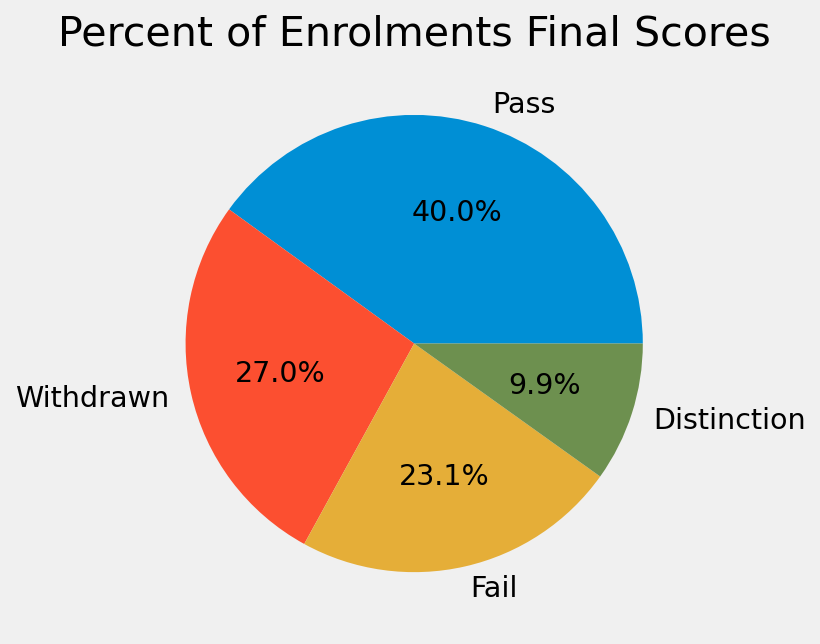

In [45]:
fig, ax = plt.subplots(dpi = 147)
student_results.plot(kind="pie", y=' ', autopct='%1.1f%%', textprops=dict(color="k"))
plt.axis('off')
ax.set_title('Percent of Enrolments Final Scores', color='k')

In [48]:
# See how many students have unregistered before the course started
bf_course_df = student_df.loc[student_df['date_unregistration'] <= -11].copy()
display(bf_course_df)
display(bf_course_df.describe())
#display(student_df.loc[student_df['date_registration'].isnull()])
display(bf_course_df['final_result'].value_counts())
bf_course_df.info()

#remove from dataset as these people never interacted with the course material
student_df = student_df[~student_df['id_student'].isin(bf_course_df)]

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration
716,AAA,2014J,2318055,Pass,-56.0,-19.0
987,BBB,2013B,335910,Fail,-184.0,-43.0
1816,BBB,2013B,543356,Pass,-52.0,-23.0
2812,BBB,2013J,393327,Pass,-128.0,-109.0
3271,BBB,2013J,546941,Distinction,-53.0,-30.0
...,...,...,...,...,...,...
35251,GGG,2014B,542562,Pass,-225.0,-212.0
35253,GGG,2014B,542562,Pass,-85.0,-73.0
35258,GGG,2014B,548578,Fail,-89.0,-87.0
35639,GGG,2014B,625903,Pass,-78.0,-18.0


,date_registration,date_unregistration
count,246.000000,252.000000
mean,-117.556911,-66.781746
std,59.090201,50.987812
min,-320.000000,-365.000000
25%,-148.000000,-87.500000
50%,-115.000000,-53.000000
75%,-78.000000,-26.000000
max,-17.000000,-11.000000


final_result
Pass           150
Fail            77
Distinction     25
Name: count, dtype: Int64

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 716 to 35732
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          252 non-null    string 
 1   code_presentation    252 non-null    string 
 2   id_student           252 non-null    string 
 3   final_result         252 non-null    string 
 4   date_registration    246 non-null    float64
 5   date_unregistration  252 non-null    float64
dtypes: float64(2), string(4)
memory usage: 13.8 KB


None

Text(0.5, 1.0, 'Percent of scores of unregistered enrolments\n before the course started')

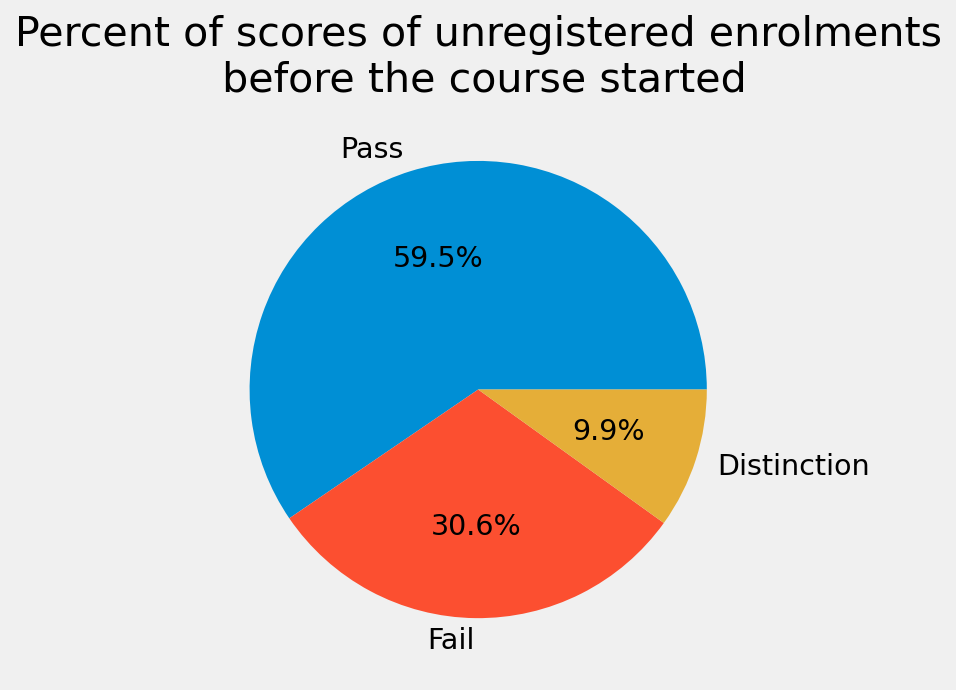

In [72]:
fig, ax = plt.subplots(dpi = 147)
bf_course_df['final_result'].value_counts().plot(kind="pie", y=' ', autopct='%1.1f%%', textprops=dict(color="k"))
plt.axis('off')
ax.set_title('Percent of Final Scores of unregistered enrolments\n before the course started', color='k')

## Student Interaction with course material

In [7]:
## need to add the Vle connected to Student Vle
vle_ds = engine.execute(text("""
SELECT cast(vle.id_site as text), vle.code_module, vle.code_presentation, vle.activity_type, vle.week_from, vle.week_to, cast(sVle.id_student as text), sVle.date, SUM(sVLe.sum_click) as sum_click
FROM vle
LEFT JOIN studentVle AS sVle ON vle.id_site = sVle.id_site AND vle.code_presentation = sVle.code_presentation AND vle.code_module = sVle.code_module
GROUP BY vle.code_module, vle.code_presentation, sVle.id_student
""")).fetchall()
vle_df = pd.DataFrame(vle_ds, columns=['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to', 'id_student', 'date', 'sum_click'])
vle_df = vle_df.astype({'id_site':'string', 'code_module':'string', 'code_presentation':'string', 'activity_type':'string', 'id_student':'string'})

In [8]:
display(vle_df)
display(vle_df.nunique())
vle_df.info()

,id_site,code_module,code_presentation,activity_type,week_from,week_to,id_student,date,sum_click
0,546897,AAA,2013J,url,NaN,NaN,<NA>,NaN,NaN
1,546614,AAA,2013J,homepage,NaN,NaN,11391,-5.0,934.0
2,546614,AAA,2013J,homepage,NaN,NaN,28400,-10.0,1435.0
3,546614,AAA,2013J,homepage,NaN,NaN,30268,-10.0,281.0
4,546614,AAA,2013J,homepage,NaN,NaN,31604,-10.0,2158.0
...,...,...,...,...,...,...,...,...,...
29240,897051,GGG,2014J,resource,2.0,2.0,2640965,17.0,41.0
29241,896962,GGG,2014J,oucontent,NaN,NaN,2645731,110.0,893.0
29242,896956,GGG,2014J,quiz,NaN,NaN,2648187,149.0,312.0
29243,897051,GGG,2014J,resource,2.0,2.0,2679821,-6.0,275.0


id_site                623
code_module              7
code_presentation        4
activity_type           15
week_from               24
week_to                 24
id_student           26074
date                   281
sum_click             5380
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29245 entries, 0 to 29244
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            29245 non-null  string 
 1   code_module        29245 non-null  string 
 2   code_presentation  29245 non-null  string 
 3   activity_type      29245 non-null  string 
 4   week_from          4705 non-null   float64
 5   week_to            4705 non-null   float64
 6   id_student         29228 non-null  string 
 7   date               29228 non-null  float64
 8   sum_click          29228 non-null  float64
dtypes: float64(4), string(5)
memory usage: 2.0 MB


## Student Assessment

In [9]:
ass_ds = engine.execute(text("""
SELECT cast(sAss.id_student as text), ass.code_module, ass.code_presentation, cast(sAss.id_assessment as text), sAss.date_submitted
FROM studentAssessment as sAss
LEFT JOIN assessments as ass ON sAss.id_assessment = ass.id_assessment
""")).fetchall()

assessment_df = pd.DataFrame(ass_ds, columns=['id_student', 'code_module', 'code_presentation', 'id_assessent', 'date_submitted'])
assessment_df = assessment_df.astype({'id_student':'string', 'code_module':'string', 'code_presentation':'string', 'id_assessent':'string'})
display(assessment_df.describe())
assessment_df.info()

,date_submitted
count,173912.000000
mean,116.032942
std,71.484148
min,-11.000000
25%,51.000000
50%,116.000000
75%,173.000000
max,608.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id_student         173912 non-null  string
 1   code_module        173912 non-null  string
 2   code_presentation  173912 non-null  string
 3   id_assessent       173912 non-null  string
 4   date_submitted     173912 non-null  int64 
dtypes: int64(1), string(4)
memory usage: 6.6 MB


We are looking at the students that haven't haded in any assessments.

* We don't want them to skew our data as they never participated.
* There could be reasons but for the momst part the students either withdrew or failed.
* over 75% had unregistered by the 27th day of the presetation.
* It could only be assumed that the 2 that passed had prior learning or some other reason

In [10]:
students_assessed = list(assessment_df['id_student'].unique())
all_students = list(student_df['id_student'].unique())
display(f"Number of students assessed/total students: {len(list(students_assessed))}/{len(list(all_students))}")

student_not_assessed_df = student_df[~student_df['id_student'].isin(students_assessed)].copy()
display(student_not_assessed_df.nunique())
display(student_not_assessed_df['final_result'].value_counts())
display(student_not_assessed_df[['date_registration', 'date_unregistration']].describe())


'Number of students assessed/total students: 23369/27295'

code_module               7
code_presentation         4
id_student             3948
final_result              3
date_registration       227
date_unregistration     189
dtype: int64

final_result
Withdrawn    3480
Fail         1334
Pass            2
Name: count, dtype: Int64

,date_registration,date_unregistration
count,4801.000000,3535.000000
mean,-70.581546,22.876945
std,48.268486,42.463059
min,-309.000000,-232.000000
25%,-104.000000,0.000000
50%,-58.000000,12.000000
75%,-30.000000,27.000000
max,37.000000,240.000000


## The Students that have been assessed.

In [11]:
students_assessed_df = student_df[student_df['id_student'].isin(students_assessed)]
display(students_assessed_df.nunique())
display(students_assessed_df['final_result'].value_counts())
display(students_assessed_df[['date_registration', 'date_unregistration']].describe())

code_module                7
code_presentation          4
id_student             23347
final_result               4
date_registration        317
date_unregistration      354
dtype: int64

final_result
Pass           14680
Fail            7144
Withdrawn       6424
Distinction     3624
Name: count, dtype: Int64

,date_registration,date_unregistration
count,31865.000000,8057.000000
mean,-68.181861,95.841256
std,49.308932,72.560183
min,-320.000000,-365.000000
25%,-99.000000,38.000000
50%,-53.000000,95.000000
75%,-29.000000,154.000000
max,167.000000,444.000000


Text(0.5, 1.0, 'Percent of Assessed Enrolment Final Scores')

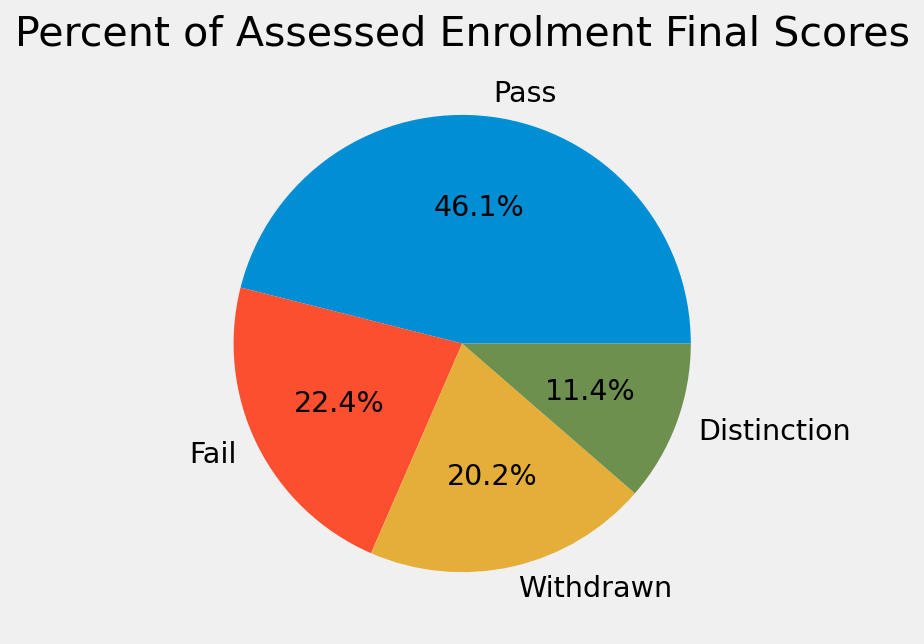

In [65]:
fig, ax = plt.subplots(dpi = 147)
students_assessed_df['final_result'].value_counts().plot(kind="pie", y=' ', autopct='%1.1f%%', textprops=dict(color="k"))
plt.axis('off')
ax.set_title('Percent of Assessed Enrolment Final Scores', color='k')

## The Students that have not been assessed but interacted.

In [12]:

student_not_assessed_interacted_df = vle_df[~vle_df['id_student'].isin(students_assessed)]
display(student_df[student_df['id_student'].isin(list(student_not_assessed_interacted_df['id_student']))].nunique())
display(student_df[student_df['id_student'].isin(list(student_not_assessed_interacted_df['id_student']))]['final_result'].value_counts())

code_module               7
code_presentation         4
id_student             2634
final_result              3
date_registration       205
date_unregistration     183
dtype: int64

final_result
Withdrawn    2337
Fail          998
Pass            1
Name: count, dtype: Int64

Text(0.5, 1.0, 'Percent of Final Scores of enrolments that\n interacted with no assessments')

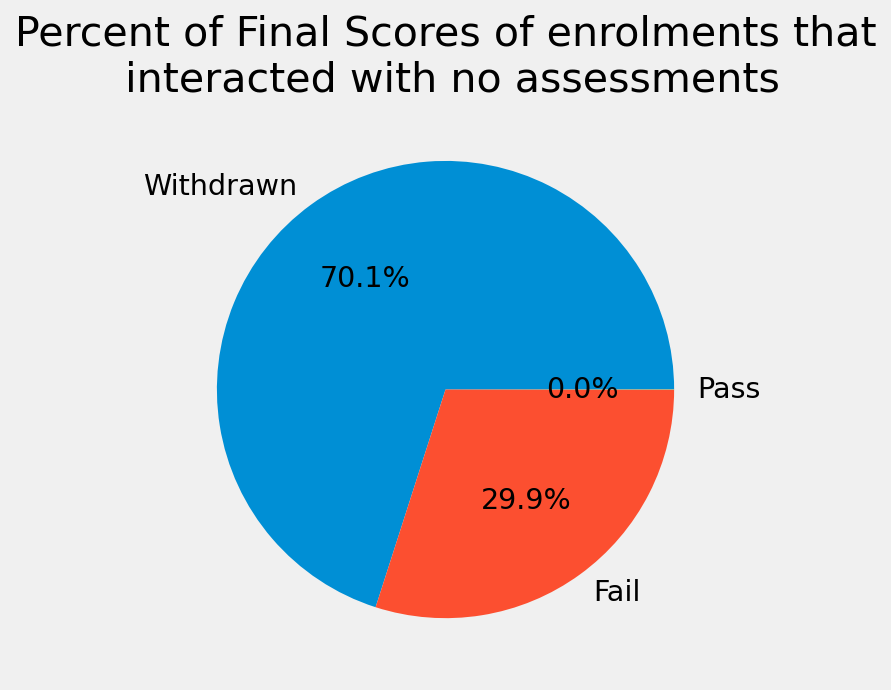

In [73]:
fig, ax = plt.subplots(dpi = 147)
student_df[student_df['id_student'].isin(list(student_not_assessed_interacted_df['id_student']))]['final_result'].value_counts().plot(kind="pie", y=' ', autopct='%1.1f%%', textprops=dict(color="k"))
plt.axis('off')
ax.set_title('Percent of Final Scores of enrolments that\n interacted with no assessments', color='k')

## The Students that have been assessed but not interacted.

In [13]:
student_assessed_not_interacted_df = student_df[(student_df['id_student'].isin(students_assessed) & ~student_df['id_student'].isin(list(vle_df['id_student'].unique())))].copy()

display(student_assessed_not_interacted_df)
display(student_assessed_not_interacted_df.nunique())
display(student_df[student_df['id_student'].isin(list(student_assessed_not_interacted_df['id_student']))]['final_result'].value_counts())

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration
1493,BBB,2013B,517853,Fail,-50.0,NaN
2752,BBB,2013J,355591,Withdrawn,-176.0,111.0
2850,BBB,2013J,415698,Withdrawn,-87.0,76.0
2892,BBB,2013J,440751,Withdrawn,-127.0,-8.0
2948,BBB,2013J,481448,Fail,-30.0,NaN
3268,BBB,2013J,546195,Fail,-10.0,NaN
3540,BBB,2013J,574810,Withdrawn,-29.0,48.0
4562,BBB,2013J,2346025,Fail,-71.0,NaN
4640,BBB,2013J,2650236,Fail,-80.0,NaN
4654,BBB,2014B,38941,Fail,-24.0,NaN


code_module             4
code_presentation       4
id_student             23
final_result            3
date_registration      22
date_unregistration     6
dtype: int64

final_result
Fail         15
Withdrawn     6
Pass          2
Name: count, dtype: Int64

Text(0.5, 1.0, 'Percent of Final Scores of enrolments that\n completed assessments but did not interact')

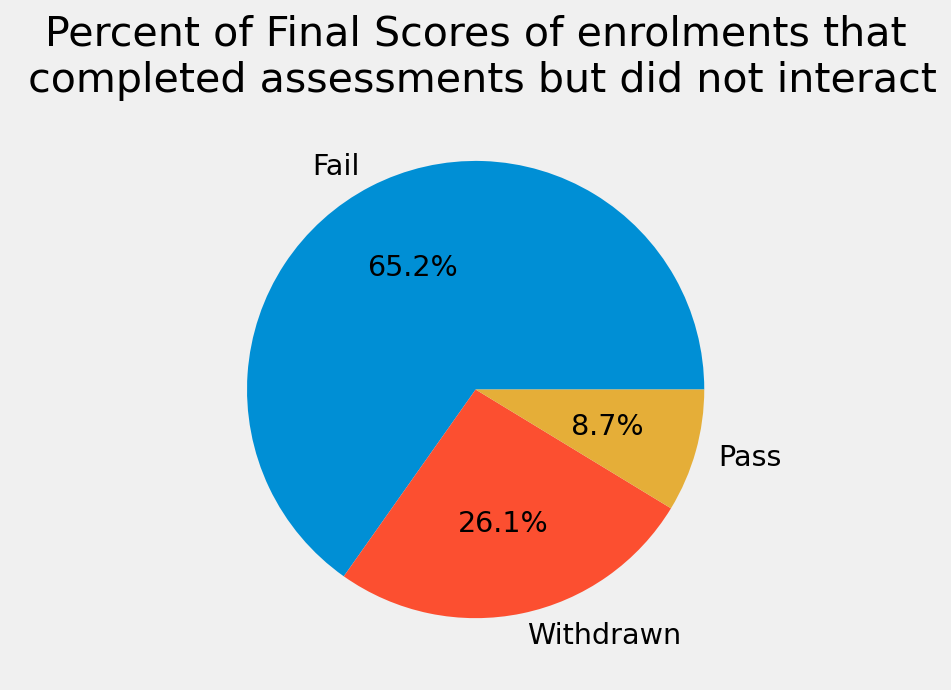

In [74]:
fig, ax = plt.subplots(dpi = 147)
student_df[student_df['id_student'].isin(list(student_assessed_not_interacted_df['id_student']))]['final_result'].value_counts().plot(kind="pie", y=' ', autopct='%1.1f%%', textprops=dict(color="k"))
plt.axis('off')
ax.set_title('Percent of Final Scores of enrolments that\n completed assessments but did not interact', color='k')

In [14]:
ou_df = pd.merge(pd.merge(student_df,assessment_df,how='left'), vle_df, how='left')

# remove students that do not hand in assessments only one passed so almost 100% fail or withdrawn
ou_df = ou_df[~ou_df['id_student'].isin(student_not_assessed_interacted_df)]

display(ou_df)
display(ou_df.nunique())
ou_df.info()

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration,id_assessent,date_submitted,id_site,activity_type,week_from,week_to,date,sum_click
0,AAA,2013J,11391,Pass,-159.0,NaN,1752,18.0,546614,homepage,NaN,NaN,-5.0,934.0
1,AAA,2013J,11391,Pass,-159.0,NaN,1753,53.0,546614,homepage,NaN,NaN,-5.0,934.0
2,AAA,2013J,11391,Pass,-159.0,NaN,1754,115.0,546614,homepage,NaN,NaN,-5.0,934.0
3,AAA,2013J,11391,Pass,-159.0,NaN,1755,164.0,546614,homepage,NaN,NaN,-5.0,934.0
4,AAA,2013J,11391,Pass,-159.0,NaN,1756,212.0,546614,homepage,NaN,NaN,-5.0,934.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209570,GGG,2014J,2684003,Distinction,-28.0,NaN,37437,169.0,896962,oucontent,NaN,NaN,149.0,616.0
209571,GGG,2014J,2684003,Distinction,-28.0,NaN,37438,73.0,896962,oucontent,NaN,NaN,149.0,616.0
209572,GGG,2014J,2684003,Distinction,-28.0,NaN,37439,150.0,896962,oucontent,NaN,NaN,149.0,616.0
209573,GGG,2014J,2684003,Distinction,-28.0,NaN,37440,172.0,896962,oucontent,NaN,NaN,149.0,616.0


code_module                7
code_presentation          4
id_student             27295
final_result               4
date_registration        320
date_unregistration      355
id_assessent             188
date_submitted           312
id_site                  606
activity_type             15
week_from                 24
week_to                   24
date                     281
sum_click               5380
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209575 entries, 0 to 209574
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   code_module          209575 non-null  string 
 1   code_presentation    209575 non-null  string 
 2   id_student           209575 non-null  string 
 3   final_result         209575 non-null  string 
 4   date_registration    209524 non-null  float64
 5   date_unregistration  29902 non-null   float64
 6   id_assessent         203702 non-null  string 
 7   date_submitted       203702 non-null  float64
 8   id_site              207412 non-null  string 
 9   activity_type        207412 non-null  string 
 10  week_from            31111 non-null   float64
 11  week_to              31111 non-null   float64
 12  date                 207412 non-null  float64
 13  sum_click            207412 non-null  float64
dtypes: float64(7), string(7)
memory usage: 22.4 MB


In [15]:
## Defining the categories:
categories = pd.Series(['Very Early', 'Early', 'Late'])

## Applying these categories to the final dataframe:
ou_df['registration'] = pd.cut(ou_df.date_registration, bins = [-322,-160,0,160], labels=categories)
ou_df.head()

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration,id_assessent,date_submitted,id_site,activity_type,week_from,week_to,date,sum_click,registration
0,AAA,2013J,11391,Pass,-159.0,NaN,1752,18.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
1,AAA,2013J,11391,Pass,-159.0,NaN,1753,53.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
2,AAA,2013J,11391,Pass,-159.0,NaN,1754,115.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
3,AAA,2013J,11391,Pass,-159.0,NaN,1755,164.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
4,AAA,2013J,11391,Pass,-159.0,NaN,1756,212.0,546614,homepage,NaN,NaN,-5.0,934.0,Early


In [16]:

ou_df['code_presentation'] = ou_df['code_presentation'].replace(['2013B', '2013J', '2014B', '2014J'], ['1', '2', '3', '4'])
ou_df.head()

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration,id_assessent,date_submitted,id_site,activity_type,week_from,week_to,date,sum_click,registration
0,AAA,2,11391,Pass,-159.0,NaN,1752,18.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
1,AAA,2,11391,Pass,-159.0,NaN,1753,53.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
2,AAA,2,11391,Pass,-159.0,NaN,1754,115.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
3,AAA,2,11391,Pass,-159.0,NaN,1755,164.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
4,AAA,2,11391,Pass,-159.0,NaN,1756,212.0,546614,homepage,NaN,NaN,-5.0,934.0,Early


In [17]:
ou_df['final_result'] = ou_df['final_result'].replace(['Pass', 'Withdrawn', 'Distinction', 'Fail'], ['1', '0', '1', '0'])
ou_df.head()

,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration,id_assessent,date_submitted,id_site,activity_type,week_from,week_to,date,sum_click,registration
0,AAA,2,11391,1,-159.0,NaN,1752,18.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
1,AAA,2,11391,1,-159.0,NaN,1753,53.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
2,AAA,2,11391,1,-159.0,NaN,1754,115.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
3,AAA,2,11391,1,-159.0,NaN,1755,164.0,546614,homepage,NaN,NaN,-5.0,934.0,Early
4,AAA,2,11391,1,-159.0,NaN,1756,212.0,546614,homepage,NaN,NaN,-5.0,934.0,Early


In [18]:
# find the min and max of the column
print('minimum:', ou_df['sum_click'].min(), '-', ou_df['sum_click'].max())

## Defining the categories label:
categories3 = pd.Series(['0-2295', '2295-4590', '4590-6885', '6885-19179', '9179-11474', '11474-13769'])

## Applying these categories both to the auxiliary and to the working datasets:
ou_df['total_clicks'] = pd.cut(ou_df.sum_click, bins = [0,2295,4590,6885,9179,11474,13769], labels=categories3)
ou_df['total_clicks'].nunique()

minimum: 1.0 - 24139.0


6

In [19]:
# fill in the 
ou_df['week_from']      = ou_df['week_from'].fillna(ou_df['week_from'].min())
ou_df['week_from']      = ou_df['week_to'].fillna(ou_df['week_from'].max())
ou_df['final_result']   = ou_df['final_result'].fillna(0)
ou_df['date']           = ou_df['date'].fillna(0)
ou_df['date_submitted'] = ou_df['date_submitted'].fillna(ou_df['date_submitted'].max())
ou_df['total_clicks']   = ou_df['total_clicks'].fillna('0-2295')
ou_df['registration']   = ou_df['registration'].fillna('Early')

# turn all columns into strings for easier use in learning models
for c in ou_df.columns:
    ou_df[c] = ou_df[c].astype("str")

ou_df['id_site']        = ou_df['id_site'].replace({'<NA>': '546712'})
ou_df['activity_type']  = ou_df['activity_type'].replace({'<NA>': 'url'})

if DEBUG:
    for c in ou_df.columns:
        print(c)
        display(ou_df[c].unique())

code_module


array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

code_presentation


array(['2', '4', '1', '3'], dtype=object)

id_student


array(['11391', '28400', '30268', ..., '2648187', '2679821', '2684003'],
      dtype=object)

final_result


array(['1', '0'], dtype=object)

date_registration


array(['-159.0', '-53.0', '-92.0', '-52.0', '-176.0', '-110.0', '-67.0',
       '-29.0', '-33.0', '-179.0', '-103.0', '-47.0', '-59.0', '-68.0',
       '-180.0', '-95.0', '-130.0', '-50.0', '-107.0', '-27.0', '-31.0',
       '-170.0', '-62.0', '-100.0', '-109.0', '5.0', '-43.0', '-26.0',
       '-32.0', '-99.0', '-82.0', '-197.0', '-143.0', '-75.0', '-96.0',
       '-195.0', '-61.0', '-37.0', '-36.0', '-132.0', '-41.0', '-138.0',
       '-174.0', '-44.0', '-16.0', '-54.0', '-64.0', '-46.0', '-24.0',
       '-117.0', '-45.0', '-162.0', '-57.0', '-39.0', '-128.0', '-74.0',
       '-12.0', '-136.0', '-73.0', '-51.0', '-169.0', '-172.0', '-108.0',
       '-165.0', '-58.0', '-79.0', '2.0', '-151.0', '-198.0', '-186.0',
       '-145.0', '-191.0', '-17.0', '-11.0', '-8.0', '-141.0', '-80.0',
       '-22.0', '-115.0', '-83.0', '-18.0', '-66.0', '-123.0', '-121.0',
       '-192.0', '-196.0', '48.0', '-71.0', '-81.0', '-60.0', '-49.0',
       '-38.0', '-129.0', '-4.0', '-19.0', '-87.0', '-155.0'

date_unregistration


array(['nan', '12.0', '96.0', '72.0', '175.0', '135.0', '143.0', '24.0',
       '30.0', '144.0', '129.0', '58.0', '158.0', '191.0', '123.0',
       '201.0', '60.0', '185.0', '166.0', '109.0', '170.0', '187.0',
       '177.0', '-3.0', '53.0', '65.0', '160.0', '51.0', '5.0', '202.0',
       '172.0', '119.0', '240.0', '73.0', '128.0', '150.0', '241.0',
       '23.0', '173.0', '203.0', '63.0', '27.0', '37.0', '103.0', '-2.0',
       '138.0', '163.0', '10.0', '178.0', '242.0', '220.0', '114.0',
       '219.0', '13.0', '199.0', '93.0', '39.0', '164.0', '235.0',
       '207.0', '234.0', '104.0', '67.0', '229.0', '132.0', '165.0',
       '227.0', '18.0', '174.0', '80.0', '9.0', '228.0', '180.0', '182.0',
       '213.0', '32.0', '108.0', '110.0', '34.0', '55.0', '146.0',
       '-19.0', '38.0', '226.0', '-8.0', '153.0', '139.0', '59.0', '86.0',
       '42.0', '-4.0', '157.0', '68.0', '11.0', '76.0', '33.0', '25.0',
       '6.0', '-1.0', '-9.0', '-7.0', '-5.0', '208.0', '95.0', '48.0',
       '1

id_assessent


array(['1752', '1753', '1754', '1755', '1756', '<NA>', '1758', '1759',
       '1760', '1761', '1762', '14984', '14985', '14991', '14992',
       '14986', '14987', '14988', '14989', '14993', '14994', '14995',
       '14996', '14997', '14998', '14999', '15000', '15001', '15003',
       '15004', '15005', '15006', '15007', '15009', '15015', '15008',
       '15010', '15016', '15017', '15011', '15012', '15013', '15018',
       '15019', '15020', '15021', '15022', '15023', '15024', '24286',
       '24287', '24282', '24283', '24284', '24285', '24288', '24289',
       '24290', '24291', '24292', '24293', '24294', '24295', '24296',
       '24297', '24298', '24299', '25334', '25341', '25335', '25336',
       '25337', '25338', '25342', '25343', '25344', '25345', '25346',
       '25339', '25340', '25347', '25348', '25349', '25350', '25351',
       '25352', '25353', '25354', '25355', '25356', '25357', '25358',
       '25359', '25360', '25361', '25362', '25363', '25364', '25365',
       '25366', '25367

date_submitted


array(['18.0', '53.0', '115.0', '164.0', '212.0', '22.0', '52.0', '121.0',
       '608.0', '17.0', '51.0', '165.0', '213.0', '26.0', '75.0', '124.0',
       '181.0', '222.0', '19.0', '64.0', '117.0', '166.0', '215.0',
       '20.0', '54.0', '216.0', '57.0', '116.0', '227.0', '173.0', '9.0',
       '114.0', '161.0', '214.0', '119.0', '50.0', '198.0', '120.0',
       '170.0', '21.0', '122.0', '220.0', '49.0', '106.0', '157.0',
       '202.0', '171.0', '218.0', '16.0', '30.0', '62.0', '32.0', '55.0',
       '10.0', '61.0', '113.0', '123.0', '131.0', '47.0', '163.0',
       '208.0', '25.0', '127.0', '15.0', '65.0', '56.0', '177.0', '183.0',
       '172.0', '63.0', '108.0', '90.0', '66.0', '138.0', '168.0', '68.0',
       '180.0', '239.0', '209.0', '118.0', '158.0', '24.0', '33.0',
       '60.0', '58.0', '159.0', '217.0', '27.0', '179.0', '23.0', '219.0',
       '210.0', '42.0', '153.0', '175.0', '37.0', '67.0', '169.0', '59.0',
       '29.0', '72.0', '110.0', '176.0', '125.0', '174.0', '48

id_site


array(['546614', '546888', '546712', '546943', '546998', '547035',
       '877223', '877032', '877025', '877012', '877061', '877030',
       '877094', '877064', '877162', '877098', '877045', '877085',
       '877069', '877260', '877091', '877220', '877263', '877029',
       '877423', '877211', '543088', '542803', '543071', '543199',
       '543037', '543190', '542894', '542799', '543074', '543040',
       '542808', '543268', '542864', '542891', '542796', '543236',
       '543057', '543068', '542792', '543202', '543054', '543253',
       '543193', '543020', '542812', '543306', '543282', '542811',
       '543138', '543324', '543273', '543196', '543294', '542807',
       '543189', '543181', '543100', '542795', '543038', '543031',
       '543274', '703732', '703939', '704224', '703722', '704206',
       '703737', '704084', '703945', '703983', '703721', '703948',
       '703894', '703951', '704203', '703942', '704113', '703729',
       '704081', '703901', '704116', '703986', '703725', '7039

activity_type


array(['homepage', 'url', 'oucontent', 'resource', 'forumng', 'glossary',
       'dataplus', 'subpage', 'quiz', 'ouelluminate', 'oucollaborate',
       'externalquiz', 'ouwiki', 'page', 'questionnaire'], dtype=object)

week_from


array(['29.0', '1.0', '9.0', '4.0', '8.0', '11.0', '19.0', '6.0', '22.0',
       '2.0', '3.0', '27.0', '23.0', '5.0', '15.0', '14.0', '20.0',
       '21.0', '7.0', '12.0', '18.0', '28.0', '13.0', '10.0'],
      dtype=object)

week_to


array(['nan', '1.0', '9.0', '4.0', '8.0', '11.0', '19.0', '6.0', '22.0',
       '2.0', '3.0', '27.0', '23.0', '5.0', '15.0', '14.0', '20.0',
       '21.0', '7.0', '29.0', '12.0', '18.0', '28.0', '13.0', '10.0'],
      dtype=object)

date


array(['-5.0', '-10.0', '222.0', '217.0', '63.0', '-9.0', '23.0', '177.0',
       '240.0', '168.0', '207.0', '191.0', '203.0', '-8.0', '190.0',
       '200.0', '-3.0', '140.0', '12.0', '16.0', '193.0', '184.0', '2.0',
       '189.0', '3.0', '27.0', '211.0', '0.0', '180.0', '-7.0', '194.0',
       '166.0', '196.0', '-1.0', '-6.0', '91.0', '10.0', '229.0', '-2.0',
       '192.0', '167.0', '107.0', '181.0', '1.0', '227.0', '185.0',
       '188.0', '201.0', '241.0', '-4.0', '226.0', '9.0', '37.0', '7.0',
       '209.0', '208.0', '68.0', '31.0', '221.0', '100.0', '187.0',
       '123.0', '21.0', '173.0', '186.0', '202.0', '210.0', '224.0',
       '156.0', '128.0', '197.0', '164.0', '22.0', '153.0', '84.0',
       '14.0', '205.0', '110.0', '121.0', '53.0', '195.0', '169.0',
       '212.0', '25.0', '172.0', '175.0', '117.0', '-20.0', '-15.0',
       '94.0', '-19.0', '-23.0', '8.0', '79.0', '99.0', '114.0', '136.0',
       '65.0', '101.0', '-12.0', '98.0', '72.0', '87.0', '-14.0', '75.0',
    

sum_click


array(['934.0', '1435.0', '281.0', ..., '3773.0', '1817.0', '8398.0'],
      dtype=object)

registration


array(['Early', 'Very Early', 'Late'], dtype=object)

total_clicks


array(['0-2295', '2295-4590', '4590-6885', '6885-19179', '11474-13769',
       '9179-11474'], dtype=object)

In [20]:

del ou_df['date_registration']
del ou_df['id_student']
#del ou_df['code_presentation']
del ou_df['sum_click']
del ou_df['week_to']
del ou_df['week_from']
#del ou_df['date']
#del ou_df['date_submitted']
del ou_df['id_assessent']
del ou_df['date_unregistration']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [22]:
# get the locations
X = ou_df.iloc[:, :]
y = ou_df.iloc[:, :]
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0)

In [23]:
X_train.describe(include=['O'])

,code_module,code_presentation,final_result,date_submitted,id_site,activity_type,date,registration,total_clicks
count,146702,146702,146702,146702,146702,146702,146702,146702,146702
unique,7,4,2,303,579,15,281,3,6
top,FFF,4,1,608.0,716742,resource,0.0,Early,0-2295
freq,44586,45907,108038,4075,11054,32800,4563,139659,103936


In [24]:
combine = [X_train, X_test]

In [25]:
module_converting = {'AAA':1, 'BBB':2, 'CCC':3, 'DDD':4, 'EEE':5, 'FFF':6, 'GGG':7}
for dataset in combine:
    dataset['code_module'] = dataset['code_module'].map(module_converting)

X_train.head()

,code_module,code_presentation,final_result,date_submitted,id_site,activity_type,date,registration,total_clicks
76088,3,4,1,31.0,942322,subpage,207.0,Early,0-2295
183804,6,4,0,100.0,883048,subpage,117.0,Early,2295-4590
160319,6,2,1,237.0,716742,resource,-6.0,Early,2295-4590
176109,6,4,0,608.0,882922,resource,-15.0,Early,0-2295
30016,2,2,1,168.0,703732,forumng,1.0,Early,0-2295


In [26]:
module_converting = {'0-2295':1, '2295-4590':2, '4590-6885':3, '6885-19179':4, '9179-11474':5, '11474-13769':6}
for dataset in combine:
    dataset['total_clicks'] = dataset['total_clicks'].map(module_converting)

X_train.head()

,code_module,code_presentation,final_result,date_submitted,id_site,activity_type,date,registration,total_clicks
76088,3,4,1,31.0,942322,subpage,207.0,Early,1
183804,6,4,0,100.0,883048,subpage,117.0,Early,2
160319,6,2,1,237.0,716742,resource,-6.0,Early,2
176109,6,4,0,608.0,882922,resource,-15.0,Early,1
30016,2,2,1,168.0,703732,forumng,1.0,Early,1


In [27]:

module_converting = {'url':1, 'oucontent':2, 'resource':3, 'forumng':4, 'quiz':5, 'subpage':6,
       'homepage':7, 'oucollaborate':8, 'externalquiz':9, 'ouelluminate':10}
for dataset in combine:
    dataset['activity_type'] = dataset['activity_type'].map(module_converting)
    dataset['activity_type'] = dataset['activity_type'].fillna(1)

X_train.head()

,code_module,code_presentation,final_result,date_submitted,id_site,activity_type,date,registration,total_clicks
76088,3,4,1,31.0,942322,6.0,207.0,Early,1
183804,6,4,0,100.0,883048,6.0,117.0,Early,2
160319,6,2,1,237.0,716742,3.0,-6.0,Early,2
176109,6,4,0,608.0,882922,3.0,-15.0,Early,1
30016,2,2,1,168.0,703732,4.0,1.0,Early,1


In [28]:
module_converting = {'Very Early':1, 'Early':2, 'Late':3}
for dataset in combine:
    dataset['registration'] = dataset['registration'].map(module_converting)
    dataset['registration'] = dataset['registration'].fillna(2)

X_train.head()

,code_module,code_presentation,final_result,date_submitted,id_site,activity_type,date,registration,total_clicks
76088,3,4,1,31.0,942322,6.0,207.0,2,1
183804,6,4,0,100.0,883048,6.0,117.0,2,2
160319,6,2,1,237.0,716742,3.0,-6.0,2,2
176109,6,4,0,608.0,882922,3.0,-15.0,2,1
30016,2,2,1,168.0,703732,4.0,1.0,2,1


In [29]:
X_train_r = X_train.drop("final_result", axis=1)
Y_train_r = X_train["final_result"]
X_test_r = X_test.drop("final_result", axis=1).copy()
X_train_r.shape, Y_train_r.shape, X_test_r.shape

((146702, 8), (146702,), (62873, 8))

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train_r, Y_train_r)
Y_pred = logreg.predict(X_test_r)
acc_log = round(logreg.score(X_train_r, Y_train_r) * 100, 2)
acc_log

75.06

In [31]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
5,date,0.006638
7,total_clicks,0.000109
0,code_presentation,0.000070
6,registration,0.000005
3,id_site,0.000001
4,activity_type,-0.000028
1,final_result,-0.000032
2,date_submitted,-0.001130


In [32]:
svc = SVC()
svc.fit(X_train_r, Y_train_r)
Y_pred = svc.predict(X_test_r)
acc_svc = round(svc.score(X_train_r, Y_train_r) * 100, 2)
acc_svc

73.64

In [33]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_r, Y_train_r)
Y_pred = knn.predict(X_test_r)
acc_knn = round(knn.score(X_train_r, Y_train_r) * 100, 2)
acc_knn

87.03

In [34]:
gaussian = GaussianNB()
gaussian.fit(X_train_r, Y_train_r)
Y_pred = gaussian.predict(X_test_r)
acc_gaussian = round(gaussian.score(X_train_r, Y_train_r) * 100, 2)
acc_gaussian

76.47

In [56]:
linear_svc = LinearSVC(dual='auto',max_iter=12000)
linear_svc.fit(X_train_r, Y_train_r)
Y_pred = linear_svc.predict(X_test_r)
acc_linear_svc = round(linear_svc.score(X_train_r, Y_train_r) * 100, 2)
acc_linear_svc

74.78

In [36]:
sgd = SGDClassifier()
sgd.fit(X_train_r, Y_train_r)
Y_pred = sgd.predict(X_test_r)
acc_sgd = round(sgd.score(X_train_r, Y_train_r) * 100, 2)
acc_sgd

73.64

In [37]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_r, Y_train_r)
Y_pred = decision_tree.predict(X_test_r)
acc_decision_tree = round(decision_tree.score(X_train_r, Y_train_r) * 100, 2)
acc_decision_tree

93.1

In [38]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_r, Y_train_r)
Y_pred = random_forest.predict(X_test_r)
random_forest.score(X_train_r, Y_train_r)
acc_random_forest = round(random_forest.score(X_train_r, Y_train_r) * 100, 2)
acc_random_forest

93.09

In [63]:
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'KNN', 
              'Naive Bayes', 'Logistic Regression', 'Linear SVC'
              , 'Support Vector Machines', 'Stochastic Gradient Decent'],
    'Score': [acc_decision_tree, acc_random_forest, acc_knn, 
              acc_gaussian, acc_log, acc_linear_svc,
              acc_svc, acc_sgd ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Decision Tree,93.10
1,Random Forest,93.09
2,KNN,87.03
3,Naive Bayes,76.47
4,Logistic Regression,75.06
5,Linear SVC,74.78
6,Support Vector Machines,73.64
7,Stochastic Gradient Decent,73.64
